# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:## Implementation work

### Loading the data

In [50]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruial\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Implementation work

### Loading the data

In [26]:
train = pd.read_csv('./data/train.csv').sample(1000)
test = pd.read_csv('./data/test.csv').sample(216)
train.head()


,class_index,review_title,review_text
1344359,1,"Gossip, gossip",This book is the equivalent of a British tablo...
1896337,2,Semi-Helpful,If your interested in looking for alternative ...
1438298,2,"Someone Please Do Justice to ""Miss Saigon""",As some of the reviewers below have pointed ou...
58823,4,Entertaining.,This book had a very good plot. I liked it and...
398506,2,"All hype, nothing solid","As a well-seasoned teacher, I was excited when..."


### Searching for null values

In [3]:
print("Columns with empty review text", len(train.loc[train['review_text'] == ""]))
print("Columns with missing review text", len(train.loc[train['review_text'] == None]))

print("Columns with empty review title", len(train.loc[train['review_title'] == ""]))
print("Columns with missing review title", len(train.loc[train['review_title'] == None]))

print("Columns with empty class index", len(train.loc[train['class_index'] == ""]))
print("Columns with missing class index", len(train.loc[train['class_index'] == None]))

Columns with empty review text 0
Columns with missing review text 0
Columns with empty review title 0
Columns with missing review title 0
Columns with empty class index 0
Columns with missing class index 0


As we can see, the dataset does not contain any empty or missing values

### Studying the data

<AxesSubplot:>

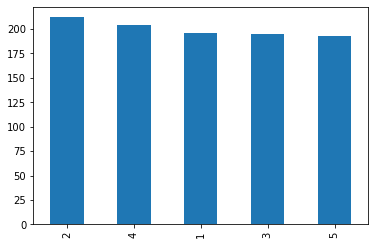

In [4]:
train['class_index'].value_counts().plot(kind='bar')

As the dataset creators have told us, the training dataset consists of 600 thousand samples for each review score, from 1 to 5.

##### Most frequent Words

c:\Users\ruial\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

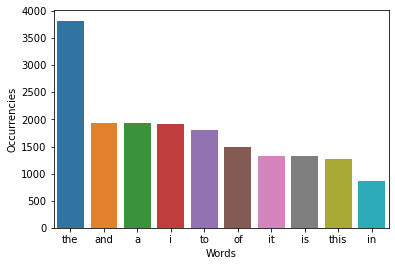

In [5]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['review_text']).lower().split()).value_counts()[:10]
mostUsedGraph = sb.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

### Treating the data
##### Cleanup and Normalization

In [27]:
ps = PorterStemmer()

def normalize(text):
    # remove non alpha chars
    text = re.sub('[^a-zA-Z]', ' ', text)
    # to lower-case and tokenize
    text = text.lower().split()
    # stemming and stop word removal
    text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

    return text

train['review_text'] = train['review_text'].apply(normalize)
train['review_title'] = train['review_title'].apply(normalize)
train.head()

test['review_text'] = test['review_text'].apply(normalize)
test['review_title'] = test['review_title'].apply(normalize)

,class_index,review_title,review_text
39135,5,fun human well cat,husband bought wonder scari killer rabbit gift...
37427,2,pain,difficult see book make pretti useless wear co...
63641,4,boy writer boy ok,beauti soul get shine take sweet time best son...
48233,1,poorli made look junki overflow,filter basket overflow except caraf coffe make...
199510,4,wish batteri,great product help find wast electr home offic...


##### Saving Preprocessed data
Since the original dataset is very large, we can sample it and save the preprocessed data in a different csv file, so it can be used later.

In [32]:
def savePreprocessedData(dataSet, fileName):
    dataSet.to_csv(fileName, index=False)

savePreprocessedData(train, './data/train_preprocessed.csv')
savePreprocessedData(test, './data/test_preprocessed.csv')

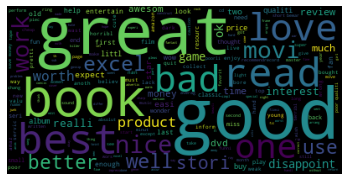

In [64]:
wordcloudTitle = WordCloud().generate(" ".join([str(x) for x in train['review_title'].values]))

plt.figure()
plt.imshow(wordcloudTitle)
plt.axis('off')
plt.show()


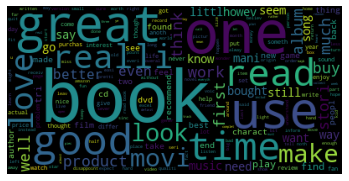

In [63]:
wordcloudText = WordCloud().generate(" ".join([str(x) for x in train['review_text'].values]))

plt.figure()
plt.imshow(wordcloudText)
plt.axis('off')
plt.show()

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [76]:
train = pd.read_csv('./data/train_preprocessed.csv')
test = pd.read_csv('./data/test_preprocessed.csv')

vectorizer = CountVectorizer()

titleWords = vectorizer.fit_transform(train['review_title'].tolist()).toarra
)

print(titleWords.shape)
print(vectorizer.get_feature_names())


SyntaxError: unmatched ')' (2524473947.py, line 7)